In [1]:
import pickle
import yaml
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import albumentations as A
import os
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import cv2
import numpy as np
import torch
from PIL import Image
import torch.utils.data
from albumentations.core.composition import Compose, OneOf
import torch.nn.functional as F
import pandas as pd

In [2]:
config={} 
with open('D:/PythonProject/pytorch-nested-unet-master/models/test_Classification_wDS_f/config.yml' , 'r') as f:
         config=yaml.safe_load(f)
print('-' * 20)
for key in config:
    print('%s: %s' % (key, config[key]))
print('-' * 20)

--------------------
arch: Classification
batch_size: 4
dataset: test
deep_supervision: True
early_stopping: -1
epochs: 100
factor: 0.1
gamma: 0.6666666666666666
img_ext: .png
input_channels: 3
input_h: 256
input_w: 256
loss: BCEWithLogitsLoss
lr: 0.001
mask_ext: .png
milestones: 1,2
min_lr: 1e-05
momentum: 0.9
name: test_Classification_wDS_f
nesterov: False
num_classes: 1
num_labelclasses: 3
num_workers: 4
optimizer: SGD
path: inputs/test/
patience: 2
scheduler: CosineAnnealingLR
seg_model: ./models/test_NestedUNet_wDS/model.pth
weight_decay: 0.0001
--------------------


In [3]:
class LoadData:
    '''
    This file for loading and caching the data and corresponding statistics
    Please note that this file needs one image and 2 labels (segmentation label and diagnostic label).
    '''
    def __init__(self, data_dir, classes, diagClasses, cached_data_file):
        self.data_dir = data_dir    #inputs/test/
        self.classes = classes     #1
        self.trainImList = list()
        self.valImList = list()
        self.trainAnnotList = list()
        self.valAnnotList = list()
        self.diagClassTrain = list()
        self.diagClassVal = list()
        self.diagClasses = diagClasses   #3
        self.cached_data_file = cached_data_file  # modelname

    def readFile(self, fileName, trainStg=False):


        with open(self.data_dir + '/' + fileName, 'r') as textFile:
            for line in textFile:
                #line = textFile.read()
                line_arr = line.split(',')
                if len(line_arr) >= 3:

                    img_file = ((self.data_dir).strip()  + line_arr[0].strip()).strip()
                    label_file = ((self.data_dir).strip()  + line_arr[1].strip()).strip()
                    class_str = line_arr[2].strip()
                    # Pad the class string with leading zeros to make it have a length of 3
                    class_str = class_str.zfill(3)
                    # Convert class_str to a list of integers
                    class_list = [int(digit) for digit in class_str]
                    #label_img = cv2.imread(label_file, 0)
                if trainStg == True:
                    self.trainImList.append(img_file)
                    self.trainAnnotList.append(label_file)
                    self.diagClassTrain.append(class_list)
                else:
                    self.valImList.append(img_file)
                    self.valAnnotList.append(label_file)
                    self.diagClassVal.append(class_list)


        return 0

    def processData(self):
        print('Processing training data')
        return_val = self.readFile('train.txt', True)

        print('Processing validation data')
        return_val1 = self.readFile('val.txt')

        print('Pickling data')
        if return_val ==0 and return_val1 ==0:
            data_dict = dict()
            data_dict['trainIm'] = self.trainImList
            data_dict['trainAnnot'] = self.trainAnnotList
            data_dict['trainDiag'] = self.diagClassTrain
            data_dict['valIm'] = self.valImList
            data_dict['valAnnot'] = self.valAnnotList
            data_dict['valDiag'] = self.diagClassVal

            pickle.dump(data_dict, open(self.cached_data_file, "wb")) # 这里打开的是什么？  name?

            return data_dict
        return None

In [4]:
class PolypDataset(Dataset):
    def __init__(self, image_path, gt, trainsize, augmentations):
        self.trainsize = trainsize
        self.augmentations = augmentations
        #图像数据
        self.images = image_path
        
        #label数据
        self.gts = gt
        #统计图像数量
        self.size = len(self.images)
        
        if self.augmentations == True:
            print('Using RandomRotation, RandomFlip')
            self.img_transform = transforms.Compose([
                transforms.RandomRotation(90, expand=False, center=None),#在[-90, 90]的范围内随机旋转图像。
                transforms.RandomVerticalFlip(p=0.5),#以50%的概率随机垂直翻转图像
                transforms.RandomHorizontalFlip(p=0.5),#以50%的概率随机水平翻转图像。
                transforms.Resize((self.trainsize, self.trainsize)),#调整图像大小为指定大小，即训练时图像的尺寸。
                #  352*352*3
                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0, hue=0),#随机调整图像亮度、对比度和饱和度。
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])#对图像进行标准化，使其每个通道的均值为0.485、0.456、0.406，
                                                             #标准差为0.229、0.224、0.225
        else:
            print('no augmentation')
            self.img_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
            

    def __getitem__(self, index):
        img_id=self.images[index]
        image = self.rgb_loader(img_id)
        gt=self.gts[index]
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        np.random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.img_transform is not None:
            image = self.img_transform(image)
        #image = image.transpose(2, 0, 1)
        label_id = torch.Tensor(gt).cuda()
        return image, label_id, {'img_id': img_id}
          

    def rgb_loader(self, path):   #用于加载图像文件并将其转换为 RGB 模式。
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __len__(self):
        return self.size

In [5]:
dataLoader = LoadData(config['path'], config['num_classes'], config['num_labelclasses'], config['name'])
data = dataLoader.processData()

train_img_ids = data['trainIm']
train_label_ids = data['trainDiag']
val_img_ids = data['valIm']
val_label_ids = data['valDiag']

Processing training data
Processing validation data
Pickling data


In [6]:
model_type = 'B4'
init_trainsize = 128
batch_size = 2
from collections import OrderedDict
from tqdm import tqdm
import torch.nn as nn
log = OrderedDict([
    ('epoch', []),
    ('lr', []),

    ('loss', []),
    ('acc', []),

    ('val_loss', []),
    ('val_acc', []),
])
best_acc = 0
trigger = 0
if config['loss'] == 'BCEWithLogitsLoss':
    criterion = nn.BCEWithLogitsLoss().cuda()

In [7]:
trainDataset = PolypDataset(train_img_ids, train_label_ids, trainsize=init_trainsize, augmentations = True)
train_loader = DataLoader(dataset=trainDataset,batch_size=batch_size,shuffle=True)
valDateset=PolypDataset(val_img_ids, val_label_ids, trainsize=init_trainsize, augmentations = False)
val_loader = DataLoader(dataset=valDateset,batch_size=batch_size,shuffle=False)

Using RandomRotation, RandomFlip
no augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


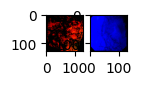

In [8]:
import matplotlib.pyplot as plt
# imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# set rows and columns
rows = 1
columns = 16

dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, masks,ids= next(dataiter)

# show images
fig = plt.figure(figsize=(9,5))
for i in range(1,3):
    fig.add_subplot(rows,columns,i)
    imshow(torchvision.utils.make_grid(images[i-1,:,:,:]))
    


In [9]:
from Encoder import mit
from Decoder import mlp
from mmcv.cnn import ConvModule
import torch.nn as nn
class ESFPNetStructure(nn.Module):

    def __init__(self, embedding_dim = 160):
        super(ESFPNetStructure, self).__init__()
        
        # Backbone
        if model_type == 'B0':
            self.backbone = mit.mit_b0()
        if model_type == 'B1':
            self.backbone = mit.mit_b1()
        if model_type == 'B2':
            self.backbone = mit.mit_b2()
        if model_type == 'B3':
            self.backbone = mit.mit_b3()
        if model_type == 'B4':
            self.backbone = mit.mit_b4()
        if model_type == 'B5':
            self.backbone = mit.mit_b5()
        
        self._init_weights()  # load pretrain
        
        # LP Header
        self.LP_1 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_2 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_3 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        self.LP_4 = mlp.LP(input_dim = self.backbone.embed_dims[3], embed_dim = self.backbone.embed_dims[3])
        
        # Linear Fuse
        self.linear_fuse34 = ConvModule(in_channels=(self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), out_channels=self.backbone.embed_dims[2], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse23 = ConvModule(in_channels=(self.backbone.embed_dims[1] + self.backbone.embed_dims[2]), out_channels=self.backbone.embed_dims[1], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse12 = ConvModule(in_channels=(self.backbone.embed_dims[0] + self.backbone.embed_dims[1]), out_channels=self.backbone.embed_dims[0], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        
        # Fused LP Header
        self.LP_12 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_23 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_34 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        
        # Final Linear Prediction
        self.linear_pred = nn.Conv2d((self.backbone.embed_dims[0] + self.backbone.embed_dims[1] + self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), 1, kernel_size=1)
        
    def _init_weights(self):
        
        if model_type == 'B0':
            pretrained_dict = torch.load('./Pretrained/mit_b0.pth')
        if model_type == 'B1':
            pretrained_dict = torch.load('./Pretrained/mit_b1.pth')
        if model_type == 'B2':
            pretrained_dict = torch.load('./Pretrained/mit_b2.pth')
        if model_type == 'B3':
            pretrained_dict = torch.load('./Pretrained/mit_b3.pth')
        if model_type == 'B4':
            pretrained_dict = torch.load('./Pretrained/mit_b4.pth')
        if model_type == 'B5':
            pretrained_dict = torch.load('./Pretrained/mit_b5.pth')
            
            
        model_dict = self.backbone.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.backbone.load_state_dict(model_dict)
        print("successfully loaded!!!!")
        
        
    def forward(self, x):
#         这段代码是一个模型的前向传递过程。该模型首先通过backbone网络，
#         对输入的x进行特征提取，得到4个不同分辨率的特征图。
#         然后将这些特征图送入LP Header网络进行处理，融合不同层次的特征。
#         接着通过上采样（interpolation）将处理后的特征图进行恢复到原始输入图像尺寸大小，
#         并最终送入线性预测器（linear_pred）获得输出结果。
        ##################  Go through backbone ###################
        
        B = x.shape[0]
        
        #stage 1
        out_1, H, W = self.backbone.patch_embed1(x)
        for i, blk in enumerate(self.backbone.block1):
            out_1 = blk(out_1, H, W)
        out_1 = self.backbone.norm1(out_1)
        #将输入特征图out_1从形状(Batch_Size, N, W, H)变形为(Batch_Size, H, W, N)
        #其中-1表示自动计算N的值。接着使用permute函数将特征维度N和高宽维度H、W交换位置
        #变成(Batch_Size, N, H, W)的形状
        out_1 = out_1.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[0], 88, 88)
        
        # stage 2
        out_2, H, W = self.backbone.patch_embed2(out_1)
        for i, blk in enumerate(self.backbone.block2):
            out_2 = blk(out_2, H, W)
        out_2 = self.backbone.norm2(out_2)
        out_2 = out_2.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[1], 44, 44)
        
        # stage 3
        out_3, H, W = self.backbone.patch_embed3(out_2)
        for i, blk in enumerate(self.backbone.block3):
            out_3 = blk(out_3, H, W)
        out_3 = self.backbone.norm3(out_3)
        out_3 = out_3.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[2], 22, 22)
        
        # stage 4
        out_4, H, W = self.backbone.patch_embed4(out_3)
        for i, blk in enumerate(self.backbone.block4):
            out_4 = blk(out_4, H, W)
        out_4 = self.backbone.norm4(out_4)
        out_4 = out_4.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[3], 11, 11)
        
        # go through LP Header
        lp_1 = self.LP_1(out_1)
        lp_2 = self.LP_2(out_2)  
        lp_3 = self.LP_3(out_3)  
        lp_4 = self.LP_4(out_4)
        
        # linear fuse and go pass LP Header     上采样并拼接
        lp_34 = self.LP_34(self.linear_fuse34(torch.cat([lp_3, F.interpolate(lp_4,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_23 = self.LP_23(self.linear_fuse23(torch.cat([lp_2, F.interpolate(lp_34,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_12 = self.LP_12(self.linear_fuse12(torch.cat([lp_1, F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        
        # get the final output
        lp4_resized = F.interpolate(lp_4,scale_factor=8,mode='bilinear', align_corners=False)
        lp3_resized = F.interpolate(lp_34,scale_factor=4,mode='bilinear', align_corners=False)
        lp2_resized = F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)
        lp1_resized = lp_12
        
        out = self.linear_pred(torch.cat([lp1_resized, lp2_resized, lp3_resized, lp4_resized], dim=1))
        out_resized = F.interpolate(out,scale_factor=4,mode='bilinear', align_corners=True)
        
        return out_resized

D:\Anaconda3\envs\meproj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class Classification(nn.Module):
    def __init__(self,pretrain_path): #num_classes :3  deep_supervision :True
        super(Classification, self).__init__()
        ESFPNetBest = torch.load(pretrain_path)
        self.segmentation_model = ESFPNetBest
        print("Pretrained weights updated successfully.")
        # Add a classification head
        cov = 1
        self.c=cov
        if self.c == 0:
            self.classification_head = nn.Sequential(
                nn.Flatten(),  # Flatten the output
                nn.Linear(64**2*4, 4096),  # Adjust the size as needed
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(4096, 256),  # Adjust the size as needed
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 3),  # Output layer with 3 classes
                nn.LogSoftmax(dim=1)
            )
        else:
            self.conv_layers = nn.Sequential(
                nn.Conv2d(4, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(16**2*512, 512),  # 调整大小以适应您的需求
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),  # 调整大小以适应您的需求
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 3),
                nn.LogSoftmax(dim=1)
            )

    def forward(self, input1):
        #分割模型输出
        segmentation_output = self.segmentation_model(input1)
        concatenated = torch.cat((input1, segmentation_output), dim=1)
        concatenated = F.max_pool2d(concatenated, kernel_size=2, stride=2)

        #分类输出
        if self.c == 0:
            classification_output = self.classification_head(concatenated)
        else:
            x = self.conv_layers(concatenated)

            classification_output = self.fc_layers(x)

        return classification_output

In [11]:
from torch.optim import lr_scheduler
import torch.optim as optim
config['seg_model']="D:\PythonProject\ESFPNet\ESFPNet-main\SaveModel\ESFP_B4_Endo_AverageOptimize_1\ESFPNet.pt"
pretrained_weights_path = config['seg_model']
model=Classification(pretrained_weights_path)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.to(device)
    print('Models moved to GPU.')

print("Model to GPU successfully.")
if isinstance(model, torch.nn.Module):  #检测模型是否是Module 的实例
    print("model successfully loaded.")
else:
    print("Error: Failed to load the model.")
params = filter(lambda p: p.requires_grad, model.parameters())
if config['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        params, lr=config['lr'], weight_decay=config['weight_decay'])
elif config['optimizer'] == 'SGD':
    optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
                          nesterov=config['nesterov'], weight_decay=config['weight_decay'])
else:
    raise NotImplementedError

if config['scheduler'] == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
elif config['scheduler'] == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config['factor'], patience=config['patience'],
                                               verbose=1, min_lr=config['min_lr'])
elif config['scheduler'] == 'MultiStepLR':
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in config['milestones'].split(',')],
                                         gamma=config['gamma'])
elif config['scheduler'] == 'ConstantLR':
    scheduler = None
else:
    raise NotImplementedError

Pretrained weights updated successfully.
Models moved to GPU.
Model to GPU successfully.
model successfully loaded.


In [12]:
from metrics import acc_score
from utils import AverageMeter, str2bool
import losses
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'acc': AverageMeter()}
    class_loss = []
    model.train()

    pbar = tqdm(total=len(train_loader))
    for input1, target, _ in train_loader:
        input1 = input1.cuda()

        target = target.cuda()

        # compute output

        output = model(input1)
        
        loss = criterion(output, target)
        acc = acc_score(output, target , target.size(0))



        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input1.size(0))
        avg_meters['acc'].update(acc, input1.size(0))


        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('acc', avg_meters['acc'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    print("train end ..")
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('acc', avg_meters['acc'].avg)])

In [15]:
def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'acc': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input1, target, _ in val_loader:
            input1 = input1.cuda()

            target = target.cuda()

            # compute output

            output = model(input1)
            loss = criterion(output, target)
            acc = acc_score(output, target,input1.size(0))
            output_probabilities = torch.exp(output)
            #print('this batch acc = %s', acc)
            #print(output_probabilities, target)

            avg_meters['loss'].update(loss.item(), input1.size(0))
            avg_meters['acc'].update(acc, input1.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('acc', avg_meters['acc'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('acc', avg_meters['acc'].avg)])


In [16]:
for epoch in range(config['epochs']):
    torch.cuda.empty_cache()
    print('Epoch [%d/%d]' % (epoch, config['epochs']))

    # train for one epoch
    train_log = train(config, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(config, val_loader, model, criterion)

    if config['scheduler'] == 'CosineAnnealingLR':
        scheduler.step()
    elif config['scheduler'] == 'ReduceLROnPlateau':
        scheduler.step(val_log['loss'])

    print('loss %.4f -  acc %.4f - val_loss %.4f - val_acc %.4f '
          % (train_log['loss'], train_log['acc'], val_log['loss'], val_log['acc'] ))

    log['epoch'].append(epoch)
    log['lr'].append(config['lr'])
    log['loss'].append(train_log['loss'])
    log['acc'].append(train_log['acc'])

    log['val_loss'].append(val_log['loss'])
    log['val_acc'].append(val_log['acc'])


    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                             config['name'], index=False)

    trigger += 1

    if val_log['acc'] > best_acc:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                   config['name'])
        best_acc = val_log['acc']
        print("=> saved best model")
        #torch.save(model, 'D:/PythonProject/ESFPNet/ESFPNet-main/models/test_Classification_wDS_f/class_ESFPNet.pt')
        trigger = 0

    # early stopping
    if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

Epoch [0/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.68it/s, loss=0.602, acc=0.396]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.61it/s, loss=0.572, acc=0.536]


loss 0.6017 -  acc 0.3961 - val_loss 0.5716 - val_acc 0.5355 
=> saved best model
Epoch [1/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.58it/s, loss=0.564, acc=0.527]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.81it/s, loss=0.543, acc=0.639]


loss 0.5643 -  acc 0.5268 - val_loss 0.5428 - val_acc 0.6393 
=> saved best model
Epoch [2/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.60it/s, loss=0.566, acc=0.543]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.82it/s, loss=0.549, acc=0.617]


loss 0.5662 -  acc 0.5433 - val_loss 0.5493 - val_acc 0.6175 
Epoch [3/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.532, acc=0.623]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.76it/s, loss=0.552, acc=0.617]


loss 0.5320 -  acc 0.6231 - val_loss 0.5518 - val_acc 0.6175 
Epoch [4/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.63it/s, loss=0.51, acc=0.645]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.79it/s, loss=0.471, acc=0.765]


loss 0.5104 -  acc 0.6451 - val_loss 0.4710 - val_acc 0.7650 
=> saved best model
Epoch [5/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.506, acc=0.678]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.63it/s, loss=0.456, acc=0.743]


loss 0.5060 -  acc 0.6781 - val_loss 0.4564 - val_acc 0.7432 
Epoch [6/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.489, acc=0.692]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.95it/s, loss=0.456, acc=0.743]


loss 0.4895 -  acc 0.6919 - val_loss 0.4562 - val_acc 0.7432 
Epoch [7/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.65it/s, loss=0.471, acc=0.729]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 19.13it/s, loss=0.434, acc=0.749]


loss 0.4715 -  acc 0.7290 - val_loss 0.4342 - val_acc 0.7486 
Epoch [8/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.455, acc=0.741]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.35it/s, loss=0.429, acc=0.798]


loss 0.4554 -  acc 0.7414 - val_loss 0.4292 - val_acc 0.7978 
=> saved best model
Epoch [9/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.431, acc=0.769]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.87it/s, loss=0.436, acc=0.77]


loss 0.4308 -  acc 0.7689 - val_loss 0.4360 - val_acc 0.7705 
Epoch [10/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.437, acc=0.794]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.59it/s, loss=0.397, acc=0.836]


loss 0.4365 -  acc 0.7937 - val_loss 0.3970 - val_acc 0.8361 
=> saved best model
Epoch [11/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.53it/s, loss=0.388, acc=0.842]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.49it/s, loss=0.419, acc=0.831]


loss 0.3875 -  acc 0.8418 - val_loss 0.4192 - val_acc 0.8306 
Epoch [12/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.381, acc=0.86]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.25it/s, loss=0.412, acc=0.858]


loss 0.3809 -  acc 0.8597 - val_loss 0.4120 - val_acc 0.8579 
=> saved best model
Epoch [13/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.56it/s, loss=0.371, acc=0.864]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.48it/s, loss=0.431, acc=0.803]


loss 0.3708 -  acc 0.8638 - val_loss 0.4307 - val_acc 0.8033 
Epoch [14/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.361, acc=0.882]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.49it/s, loss=0.34, acc=0.923]


loss 0.3606 -  acc 0.8817 - val_loss 0.3399 - val_acc 0.9235 
=> saved best model
Epoch [15/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.60it/s, loss=0.347, acc=0.89]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.56it/s, loss=0.353, acc=0.907]


loss 0.3465 -  acc 0.8900 - val_loss 0.3528 - val_acc 0.9071 
Epoch [16/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:03<00:00,  5.69it/s, loss=0.332, acc=0.911]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.43it/s, loss=0.444, acc=0.836]


loss 0.3315 -  acc 0.9106 - val_loss 0.4439 - val_acc 0.8361 
Epoch [17/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.52it/s, loss=0.344, acc=0.898]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.71it/s, loss=0.341, acc=0.902]


loss 0.3435 -  acc 0.8982 - val_loss 0.3407 - val_acc 0.9016 
Epoch [18/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.55it/s, loss=0.317, acc=0.928]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.69it/s, loss=0.375, acc=0.902]


loss 0.3165 -  acc 0.9285 - val_loss 0.3751 - val_acc 0.9016 
Epoch [19/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.57it/s, loss=0.32, acc=0.913]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.66it/s, loss=0.338, acc=0.934]


loss 0.3200 -  acc 0.9133 - val_loss 0.3383 - val_acc 0.9344 
=> saved best model
Epoch [20/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.306, acc=0.934]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.35it/s, loss=0.317, acc=0.929]


loss 0.3056 -  acc 0.9340 - val_loss 0.3170 - val_acc 0.9290 
Epoch [21/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.64it/s, loss=0.295, acc=0.944]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.33it/s, loss=0.331, acc=0.923]


loss 0.2953 -  acc 0.9436 - val_loss 0.3313 - val_acc 0.9235 
Epoch [22/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.54it/s, loss=0.352, acc=0.889]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.34it/s, loss=0.343, acc=0.902]


loss 0.3518 -  acc 0.8886 - val_loss 0.3431 - val_acc 0.9016 
Epoch [23/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.63it/s, loss=0.302, acc=0.942]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.63it/s, loss=0.381, acc=0.842]


loss 0.3016 -  acc 0.9422 - val_loss 0.3809 - val_acc 0.8415 
Epoch [24/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.58it/s, loss=0.35, acc=0.894]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.26it/s, loss=0.337, acc=0.907]


loss 0.3500 -  acc 0.8941 - val_loss 0.3374 - val_acc 0.9071 
Epoch [25/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.63it/s, loss=0.314, acc=0.933]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.55it/s, loss=0.316, acc=0.934]


loss 0.3139 -  acc 0.9326 - val_loss 0.3162 - val_acc 0.9344 
Epoch [26/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.281, acc=0.949]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.59it/s, loss=0.335, acc=0.907]


loss 0.2811 -  acc 0.9491 - val_loss 0.3346 - val_acc 0.9071 
Epoch [27/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.60it/s, loss=0.28, acc=0.955]


train end ..


100%|█████████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.24it/s, loss=0.3, acc=0.962]


loss 0.2799 -  acc 0.9546 - val_loss 0.2999 - val_acc 0.9617 
=> saved best model
Epoch [28/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.67it/s, loss=0.263, acc=0.971]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.37it/s, loss=0.321, acc=0.934]


loss 0.2629 -  acc 0.9711 - val_loss 0.3213 - val_acc 0.9344 
Epoch [29/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.256, acc=0.978]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.41it/s, loss=0.346, acc=0.907]


loss 0.2559 -  acc 0.9780 - val_loss 0.3464 - val_acc 0.9071 
Epoch [30/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.60it/s, loss=0.271, acc=0.964]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.55it/s, loss=0.414, acc=0.885]


loss 0.2710 -  acc 0.9642 - val_loss 0.4139 - val_acc 0.8852 
Epoch [31/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.59it/s, loss=0.29, acc=0.952]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.90it/s, loss=0.341, acc=0.896]


loss 0.2896 -  acc 0.9519 - val_loss 0.3412 - val_acc 0.8962 
Epoch [32/100]


100%|██████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.62it/s, loss=0.265, acc=0.97]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.61it/s, loss=0.353, acc=0.902]


loss 0.2650 -  acc 0.9697 - val_loss 0.3534 - val_acc 0.9016 
Epoch [33/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.60it/s, loss=0.252, acc=0.977]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.57it/s, loss=0.314, acc=0.94]


loss 0.2520 -  acc 0.9766 - val_loss 0.3139 - val_acc 0.9399 
Epoch [34/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.52it/s, loss=0.262, acc=0.971]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 17.99it/s, loss=0.307, acc=0.934]


loss 0.2621 -  acc 0.9711 - val_loss 0.3069 - val_acc 0.9344 
Epoch [35/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.60it/s, loss=0.254, acc=0.981]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.64it/s, loss=0.315, acc=0.94]


loss 0.2543 -  acc 0.9807 - val_loss 0.3153 - val_acc 0.9399 
Epoch [36/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:06<00:00,  5.51it/s, loss=0.259, acc=0.975]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.59it/s, loss=0.334, acc=0.929]


loss 0.2589 -  acc 0.9752 - val_loss 0.3343 - val_acc 0.9290 
Epoch [37/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.56it/s, loss=0.245, acc=0.988]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.70it/s, loss=0.322, acc=0.945]


loss 0.2448 -  acc 0.9876 - val_loss 0.3221 - val_acc 0.9454 
Epoch [38/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.62it/s, loss=0.263, acc=0.977]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 19.16it/s, loss=0.329, acc=0.94]


loss 0.2627 -  acc 0.9766 - val_loss 0.3286 - val_acc 0.9399 
Epoch [39/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.61it/s, loss=0.242, acc=0.992]


train end ..


100%|████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.67it/s, loss=0.31, acc=0.945]


loss 0.2418 -  acc 0.9917 - val_loss 0.3102 - val_acc 0.9454 
Epoch [40/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:05<00:00,  5.54it/s, loss=0.286, acc=0.956]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.69it/s, loss=0.332, acc=0.913]


loss 0.2861 -  acc 0.9560 - val_loss 0.3316 - val_acc 0.9126 
Epoch [41/100]


100%|█████████████████████████████████████████████████████████| 364/364 [01:04<00:00,  5.60it/s, loss=0.258, acc=0.983]


train end ..


100%|███████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 18.25it/s, loss=0.386, acc=0.896]


loss 0.2581 -  acc 0.9835 - val_loss 0.3860 - val_acc 0.8962 
Epoch [42/100]


 20%|███████████▍                                              | 72/364 [00:13<00:51,  5.72it/s, loss=0.294, acc=0.944]

KeyboardInterrupt: 